In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate
import numpy as np
from torch.nn import functional as F
from typing import Union
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pandas as pd
from collections import Counter

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

violet = '#702b9d'

In [2]:
train_path = '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_training'
val_path =  '/scratch/' + os.environ.get("USER", "") + '/data/jigsaw_validation'
training_file_path = os.path.join(train_path, 'train.csv')
validation_file_path = os.path.join(val_path, 'validation_data.csv')

In [3]:
toxicity_train = pd.read_csv(f'{training_file_path}')
toxicity_train

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804869,6333967,0.000000,"Maybe the tax on ""things"" would be collected w...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,399385,approved,0,0,0,0,0,0.0,0,4
1804870,6333969,0.000000,What do you call people who STILL think the di...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,399528,approved,0,0,0,0,0,0.0,0,4
1804871,6333982,0.000000,"thank you ,,,right or wrong,,, i am following ...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,...,399457,approved,0,0,0,0,0,0.0,0,4
1804872,6334009,0.621212,Anyone who is quoted as having the following e...,0.030303,0.030303,0.045455,0.621212,0.0,NaN,NaN,...,399519,approved,0,0,0,0,0,0.0,0,66


count    1.804874e+06
mean     1.030173e-01
std      1.970757e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e-01
max      1.000000e+00
Name: target, dtype: float64


<AxesSubplot:xlabel='target', ylabel='Count'>

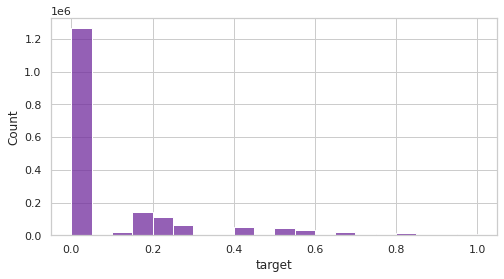

In [31]:
# take a look at distribution
print(toxicity_train.target.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.target, binwidth = .05, color = violet, ax = ax)


count    1.804874e+06
mean     4.582099e-03
std      2.286128e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: severe_toxicity, dtype: float64


<AxesSubplot:xlabel='severe_toxicity', ylabel='Count'>

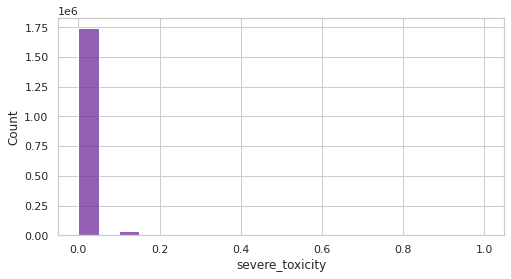

In [32]:
# take a look at distribution
print(toxicity_train.severe_toxicity.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(toxicity_train.severe_toxicity, binwidth = .05, color = violet, ax = ax)


In [16]:
train_jtc = pd.read_csv(f'{os.path.join(train_path, "train_jtc.csv")}')
train_jtc.nunique()

id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64

count    159571.000000
mean          0.095844
std           0.294379
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: toxic, dtype: float64


<AxesSubplot:xlabel='toxic', ylabel='Count'>

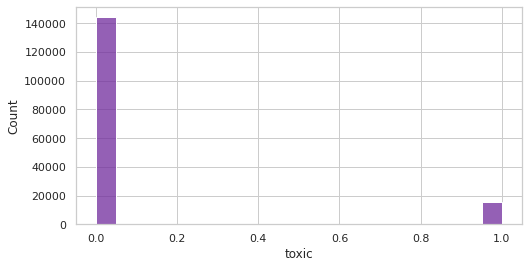

In [13]:
# take a look at distribution
print(train_jtc.toxic.describe()) ## unbalanced sample

fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.set(style="whitegrid") 
sns.histplot(train_jtc.toxic, binwidth = .05, color = violet, ax = ax)

In [28]:
toxicity_valid = pd.read_csv(f'{validation_file_path}')
print(toxicity_valid.nunique())
print(toxicity_valid.shape)

worker          753
less_toxic    11532
more_toxic    11678
dtype: int64
(30108, 3)


In [29]:
## preprocess validation dataset 
texts = set(toxicity_valid.less_toxic.to_list() + toxicity_valid.more_toxic.to_list())
text2id = {t:id for id,t in enumerate(texts)}
toxicity_valid['less_id'] = toxicity_valid['less_toxic'].map(text2id)
toxicity_valid['more_id'] = toxicity_valid['more_toxic'].map(text2id)
toxicity_valid_grouped = toxicity_valid.groupby(['less_id', 'more_id']).first().reset_index().drop(['less_id', 'more_id'], axis = 1)

In [30]:
toxicity_valid_grouped

,worker,less_toxic,more_toxic
0,421,Hebrew Name of Lydia \nAppologies to Til Eule...,"""\n\n Dear Helladios can you stop deleting my ..."
1,254,Hebrew Name of Lydia \nAppologies to Til Eule...,"""\n\n Obvious Vandalism. \n\nOkay I was readin..."
2,426,"""\n\n Gregalton: Douchemaster Supreme \n\nI'm ...",(I'm Christian I don't like the cussing going ...
3,114,Now even the discussion attempts to further co...,"""\n\nUKDoctor Replies David Ruben """"Shut Up ,..."
4,82,"Goodness \n\nYou really are a wikinazi, follo...","""\n\nDear Wikipedia """"""""Neutrality"""""""" guardia..."
...,...,...,...
15405,154,"I'm not worried about whether you've read it, ...","""\n\n An observation while copyediting \n\nWor..."
15406,417,"I'm not worried about whether you've read it, ...",""", 29 November 2006 (UTC)\n\nDon't think so th..."
15407,525,were not white! \n\npuerto ricans are not whi...,"Regarding the EVILS and the DEVILS, are you f..."
15408,345,"""every other press agency said the crowd was c...",eat me \n\ngo blow yourself
